# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>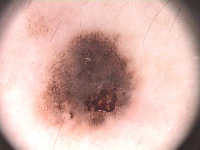</td><td>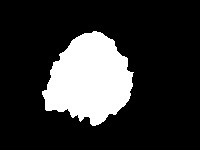</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [0]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-05-31 20:52:20--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-05-31 20:52:21--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc85cce38d57cb7d84e2efdcf6de.dl.dropboxusercontent.com/cd/0/inline/A4zw0Y9iVBoNuWxGdhX0GScy_0OFYnIYH2HhdkBHDciUxz_6hTObkSriY1eWHUbHV7aE6dyxaNYXTcI8Pv5p2-L-G-tdKJorbUki20tv7jM4HQ/file# [following]
--2020-05-31 20:52:22--  https://uc85cce38d57cb7d84e2efdcf6de.dl.dropboxusercontent.com/cd/0/inline/A4zw0Y9iVBoNuWxGdhX0GScy_0OFYnIYH2HhdkBHDciUxz_6hTObkSriY1eWHUbHV7aE6dyxaNYXTcI8Pv5p2-L-G-tdKJorbUki20tv7jM4HQ/file
Resolving 

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Если проблемы с сайтом:

In [1]:
'''from google.colab import drive
drive.mount('/content/gdrive/') 
!unrar x /content/gdrive/My\ Drive/DL\ School/Homeworks/Segmentation/PH2Dataset.rar'''

"from google.colab import drive\ndrive.mount('/content/gdrive/') \n!unrar x /content/gdrive/My\\ Drive/DL\\ School/Homeworks/Segmentation/PH2Dataset.rar"

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [0]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [0]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

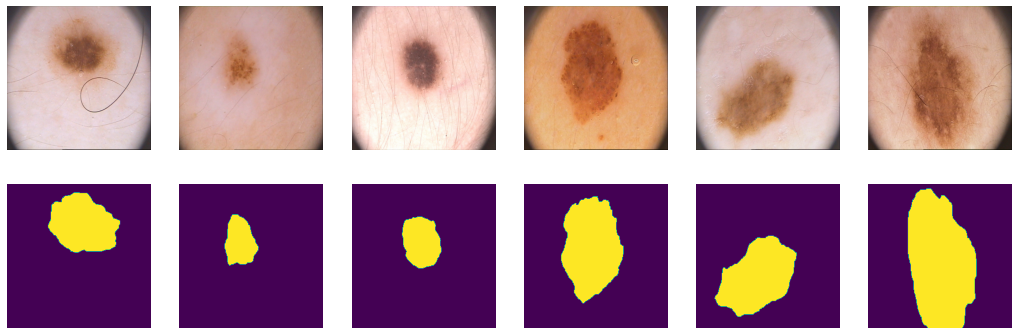

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [0]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [0]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

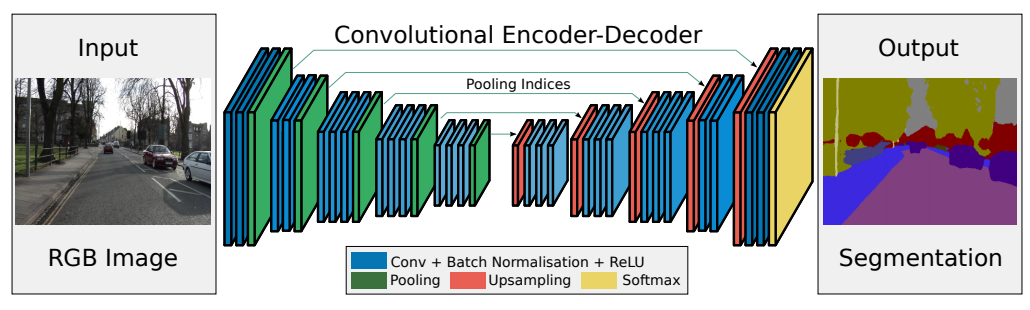

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    # TODO 
    bce_loss = y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))
    # please don't use nn.BCELoss. write it from scratch
    return bce_loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

In [0]:
segnet_bce = SegNet().to(device)

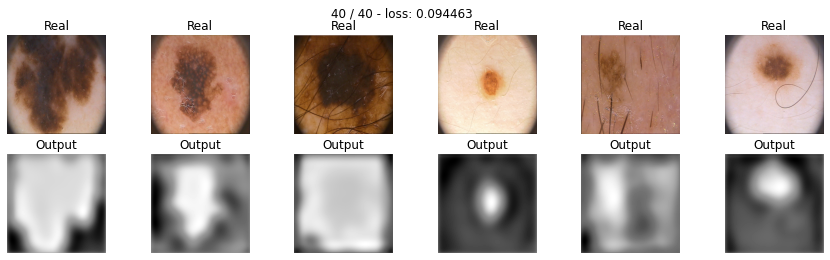

In [0]:
max_epochs = 40
optim = torch.optim.Adam(segnet_bce.parameters(), lr=1e-3)
train(segnet_bce, optim, bce_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(segnet_bce, iou_pytorch, data_val)

0.628000020980835

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = 2 * torch.sum(y_real*y_pred, dim=(2,3))
    den = torch.sum(y_real + y_pred, dim=(2,3))
    res = 1 - (num/den).mean()
    return res 

Проводим тестирование:

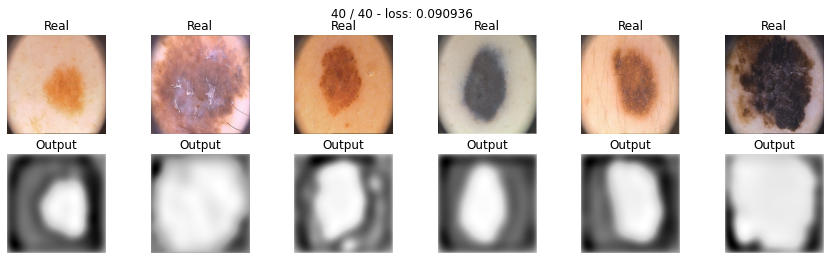

In [0]:
segnet_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(segnet_dice.parameters())
train(segnet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(segnet_dice, iou_pytorch, data_val)

0.5239999890327454

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    #y_pred =  torch.clamp(y_pred, min=0) # hint: torch.clamp
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
    y_real = y_real.contiguous().view(y_real.shape[0], -1)
    result = -((1-y_pred)**gamma*y_real*torch.log(y_pred)+(1-y_real)*torch.log(1-y_pred+eps))
    return result.mean()

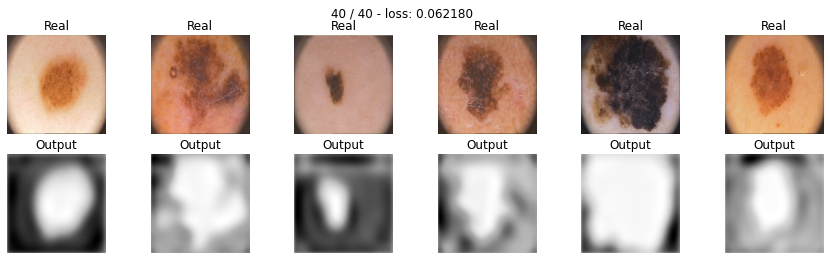

In [0]:
segnet_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(segnet_focal.parameters())
train(segnet_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(segnet_focal, iou_pytorch, data_val)

0.6439999938011169

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred, eps=1e-8, beta=0.5):
  y_pred = torch.sigmoid(y_pred)
  TP = (y_pred*y_real).sum()
  FP = ((1-y_real)*y_pred).sum()
  FN = (y_real*(1-y_pred)).sum()
  loss = 1 - (TP + eps)/(TP + (1-beta)*FN + beta*FP + eps)
  return loss

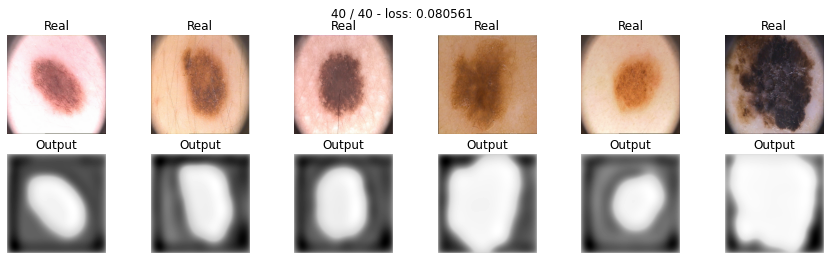

In [0]:
segnet_tversky = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(segnet_tversky.parameters())
train(segnet_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(segnet_tversky, iou_pytorch, data_val)

0.5899999737739563

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

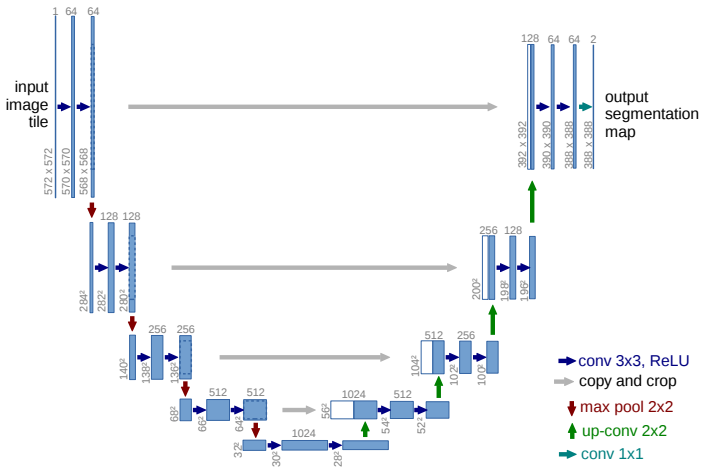

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), nn.BatchNorm2d(512))

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.relu(self.enc_conv2(self.pool1(e1)))
        e3 = F.relu(self.enc_conv3(self.pool2(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(self.pool3(e3)))
        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat((self.dec_conv0(self.upsample0(b)), e3), dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat((self.dec_conv1(self.upsample1(d0)), e2), dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat((self.dec_conv2(self.upsample2(d1)), e1), dim=1)))
        d3 = self.out(torch.cat((self.dec_conv3(self.upsample3(d2)), e0), dim=1)) # no activation
        return d3

In [0]:
unet_bce = UNet().to(device)

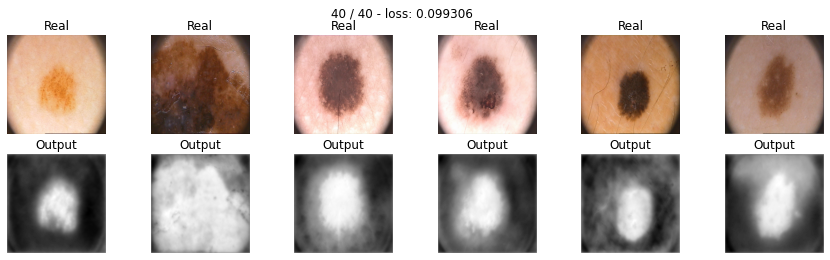

In [0]:
train(unet_bce, torch.optim.Adam(unet_bce.parameters()), bce_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_bce, iou_pytorch, data_val)

0.6579999923706055

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), nn.BatchNorm2d(512))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.relu(self.enc_conv2(self.pool1(e1)))
        e3 = F.relu(self.enc_conv3(self.pool2(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(self.pool3(e3)))
        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1)) # no activation
        return d3

In [0]:
unet2_bce = UNet2().to(device)


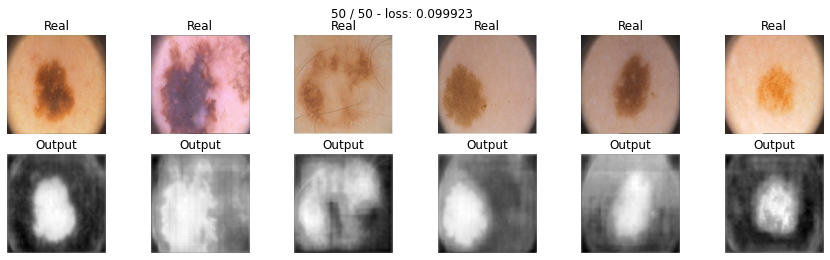

In [0]:
train(unet2_bce, torch.optim.Adam(unet2_bce.parameters()), bce_loss, 50, data_tr, data_val)

In [0]:
score_model(unet2_bce, iou_pytorch, data_val)

0.6639999747276306

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), nn.BatchNorm2d(512))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=1, dilation=3) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=1, dilation=3) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=1, dilation=3)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=1, dilation=3)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.relu(self.enc_conv2(self.pool1(e1)))
        e3 = F.relu(self.enc_conv3(self.pool2(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(self.pool3(e3)))
        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1)) # no activation
        return d3

In [0]:
dilated_bce = DilatedUNet().to(device)

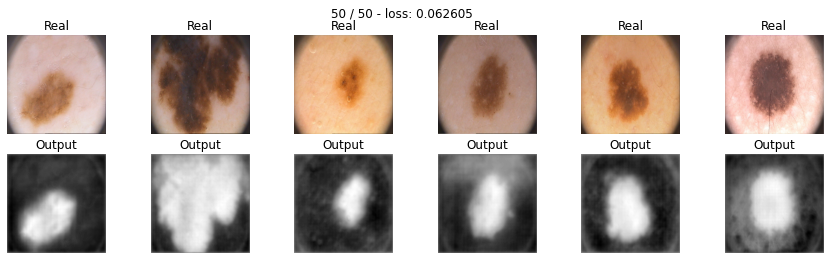

In [0]:
train(dilated_bce, torch.optim.Adam(dilated_bce.parameters()), bce_loss, 50, data_tr, data_val)

In [0]:
score_model(dilated_bce, iou_pytorch, data_val)

0.7240000367164612

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



## Функции и обучение:

Для сравнения напишем функцию, включающую в себя обучение и измерение loss и score.

In [0]:
def train1(model, opt, loss_fn, epochs, data_tr, data_val, data_ts):
    X_val, Y_val = next(iter(data_val))
    val_loss = []
    train_loss = []
    score_val = []
    score_test = []
    for epoch in range(epochs):
        v_loss = 0
        tr_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = bce_loss(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            tr_loss += loss / len(data_tr)
        train_loss.append(tr_loss.item())
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach() # detach and put into cpu
        v_loss = bce_loss(Y_val, Y_hat)
        Y_hat = Y_hat.numpy()
        val_loss.append(v_loss.item())
        score_val.append(score_model(model, iou_pytorch, data_val))
        score_test.append(score_model(model, iou_pytorch, data_ts))
    return train_loss, val_loss, score_val, score_test

Применим её во всех возможных вариациях. Для объективности сравнения параметры одинаковы.

In [0]:
segnet_bce = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(segnet_bce.parameters(), lr=1e-3)
train_loss_segnet_bce, val_loss_segnet_bce, score_val_segnet_bce, score_test_segnet_bce = train1(segnet_bce, optim, bce_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
segnet_dice = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(segnet_dice.parameters(), lr=1e-3)
train_loss_segnet_dice, val_loss_segnet_dice, score_val_segnet_dice, score_test_segnet_dice = train1(segnet_dice, optim, dice_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
segnet_focal = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(segnet_focal.parameters(), lr=1e-3)
train_loss_segnet_focal, val_loss_segnet_focal, score_val_segnet_focal, score_test_segnet_focal = train1(segnet_focal, optim, focal_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
segnet_tversky = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(segnet_tversky.parameters(), lr=1e-3)
train_loss_segnet_tversky, val_loss_segnet_tversky, score_val_segnet_tversky, score_test_segnet_tversky = train1(segnet_tversky, optim, tversky_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet_bce = UNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet_bce.parameters(), lr=1e-3)
train_loss_unet_bce, val_loss_unet_bce, score_val_unet_bce, score_test_unet_bce = train1(unet_bce, optim, bce_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet_dice = UNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet_dice.parameters(), lr=1e-3)
train_loss_unet_dice, val_loss_unet_dice, score_val_unet_dice, score_test_unet_dice = train1(unet_dice, optim, dice_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet_focal = UNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet_focal.parameters(), lr=1e-3)
train_loss_unet_focal, val_loss_unet_focal, score_val_unet_focal, score_test_unet_focal = train1(unet_focal, optim, focal_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet_tversky = UNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet_tversky.parameters(), lr=1e-3)
train_loss_unet_tversky, val_loss_unet_tversky, score_val_unet_tversky, score_test_unet_tversky = train1(unet_tversky, optim, tversky_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet2_bce = UNet2().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet2_bce.parameters(), lr=1e-3)
train_loss_unet2_bce, val_loss_unet2_bce, score_val_unet2_bce, score_test_unet2_bce = train1(unet2_bce, optim, bce_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet2_dice = UNet2().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet2_dice.parameters(), lr=1e-3)
train_loss_unet2_dice, val_loss_unet2_dice, score_val_unet2_dice, score_test_unet2_dice = train1(unet2_dice, optim, dice_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet2_focal = UNet2().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet2_focal.parameters(), lr=1e-3)
train_loss_unet2_focal, val_loss_unet2_focal, score_val_unet2_focal, score_test_unet2_focal = train1(unet2_focal, optim, focal_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
unet2_tversky = UNet2().to(device)
max_epochs = 40
optim = torch.optim.Adam(unet2_tversky.parameters(), lr=1e-3)
train_loss_unet2_tversky, val_loss_unet2_tversky, score_val_unet2_tversky, score_test_unet2_tversky = train1(unet2_tversky, optim, tversky_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
dilated_bce = DilatedUNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(dilated_bce.parameters(), lr=1e-3)
train_loss_dilated_bce, val_loss_dilated_bce, score_val_dilated_bce, score_test_dilated_bce = train1(dilated_bce, optim, bce_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
dilated_dice = DilatedUNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(dilated_dice.parameters(), lr=1e-3)
train_loss_dilated_dice, val_loss_dilated_dice, score_val_dilated_dice, score_test_dilated_dice = train1(dilated_dice, optim, dice_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
dilated_focal = DilatedUNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(dilated_focal.parameters(), lr=1e-3)
train_loss_dilated_focal, val_loss_dilated_focal, score_val_dilated_focal, score_test_dilated_focal = train1(dilated_focal, optim, focal_loss, max_epochs, data_tr, data_val, data_ts)

In [0]:
dilated_tversky = DilatedUNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(dilated_tversky.parameters(), lr=1e-3)
train_loss_dilated_tversky, val_loss_dilated_tversky, score_val_dilated_tversky, score_test_dilated_tversky = train1(dilated_tversky, optim, tversky_loss, max_epochs, data_tr, data_val, data_ts)

## **Сравнение по моделям**

###  SegNet:

Train loss

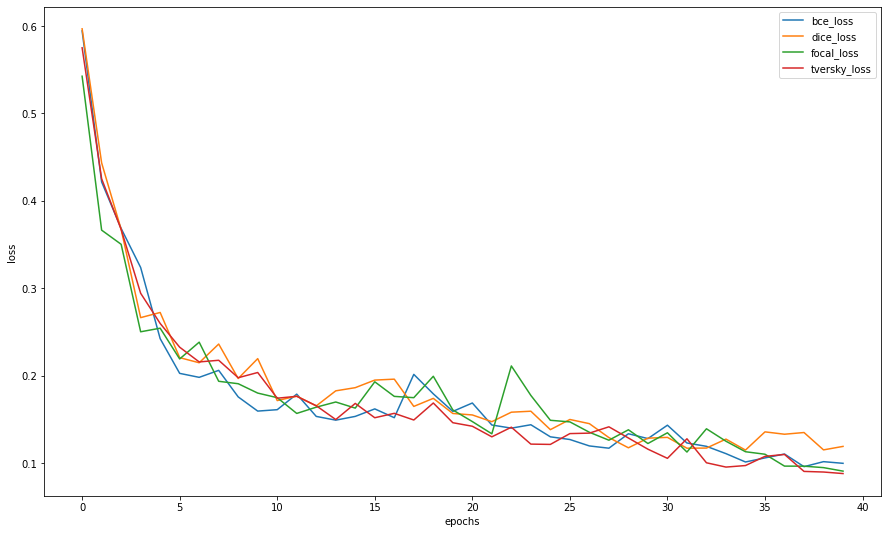

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_segnet_bce, label="bce_loss")
plt.plot(train_loss_segnet_dice, label="dice_loss")
plt.plot(train_loss_segnet_focal, label="focal_loss")
plt.plot(train_loss_segnet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

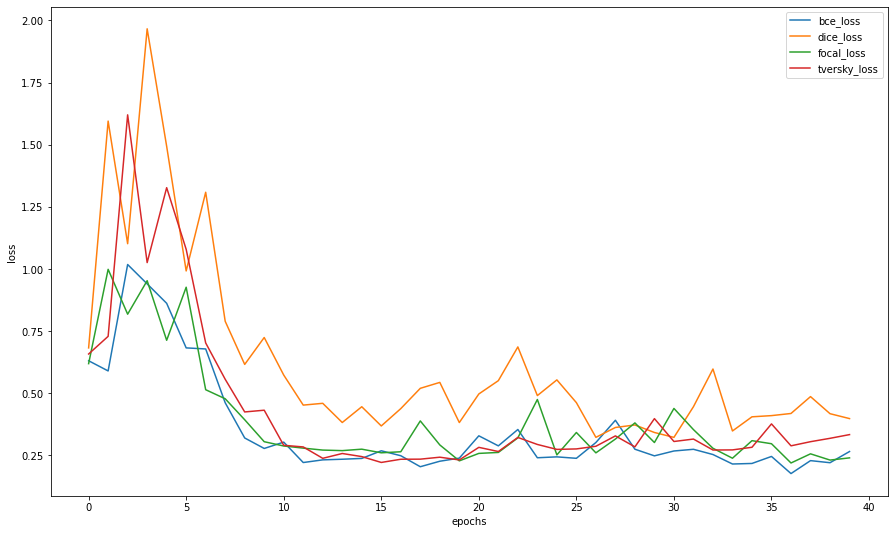

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_segnet_bce, label="bce_loss")
plt.plot(val_loss_segnet_dice, label="dice_loss")
plt.plot(val_loss_segnet_focal, label="focal_loss")
plt.plot(val_loss_segnet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val score

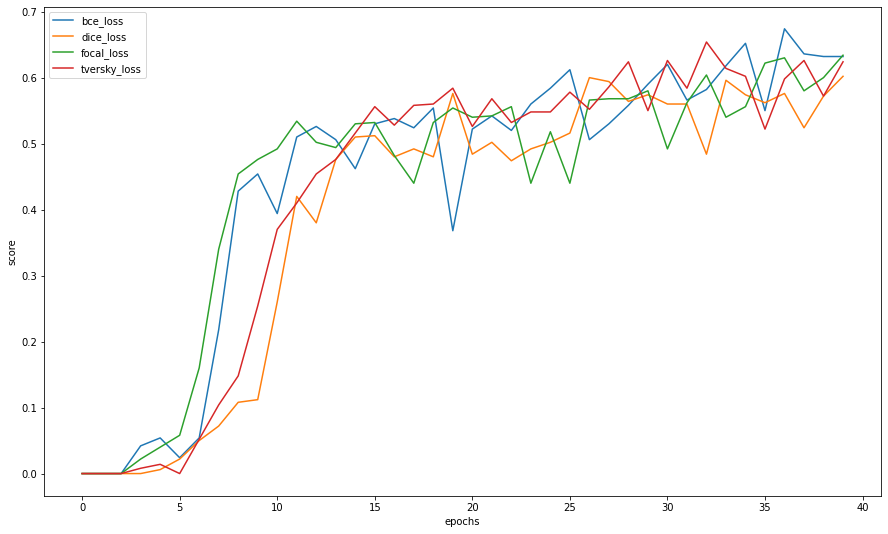

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_segnet_bce, label="bce_loss")
plt.plot(score_val_segnet_dice, label="dice_loss")
plt.plot(score_val_segnet_focal, label="focal_loss")
plt.plot(score_val_segnet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Test score

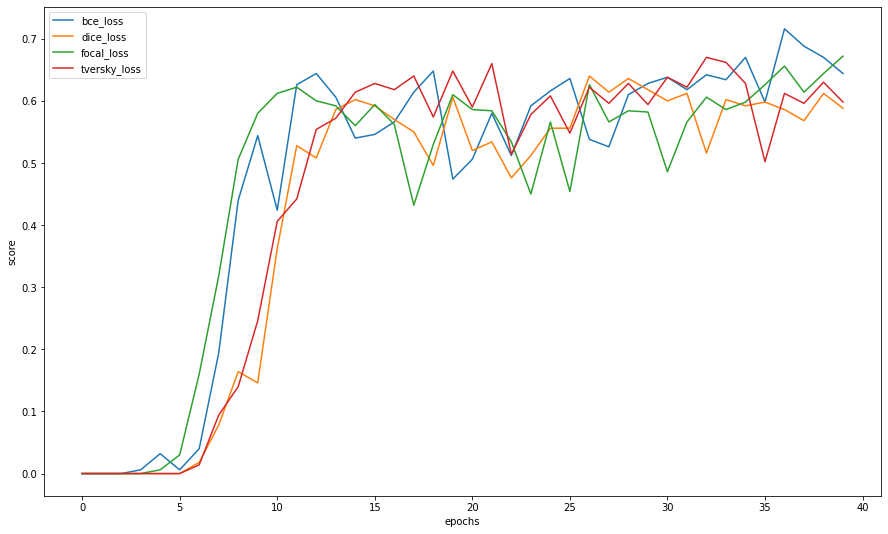

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_segnet_bce, label="bce_loss")
plt.plot(score_test_segnet_dice, label="dice_loss")
plt.plot(score_test_segnet_focal, label="focal_loss")
plt.plot(score_test_segnet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

### UNet

Train loss

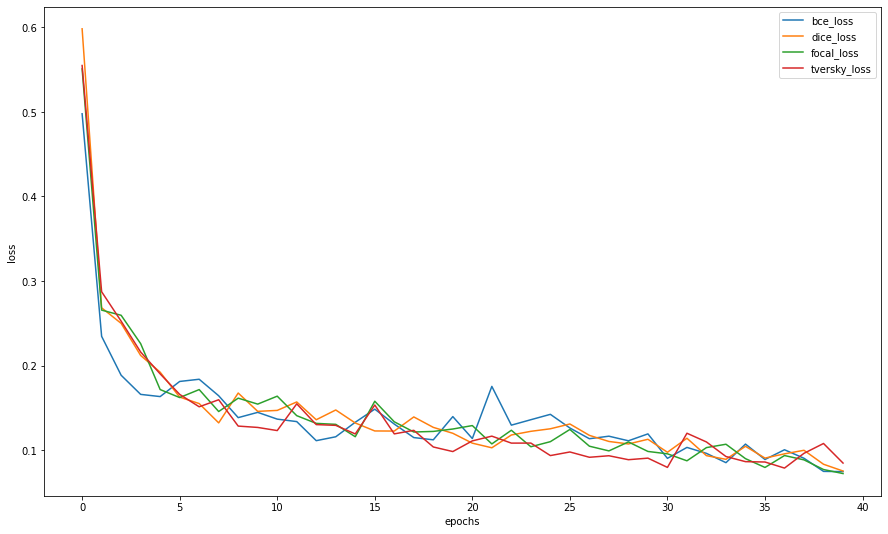

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_unet_bce, label="bce_loss")
plt.plot(train_loss_unet_dice, label="dice_loss")
plt.plot(train_loss_unet_focal, label="focal_loss")
plt.plot(train_loss_unet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

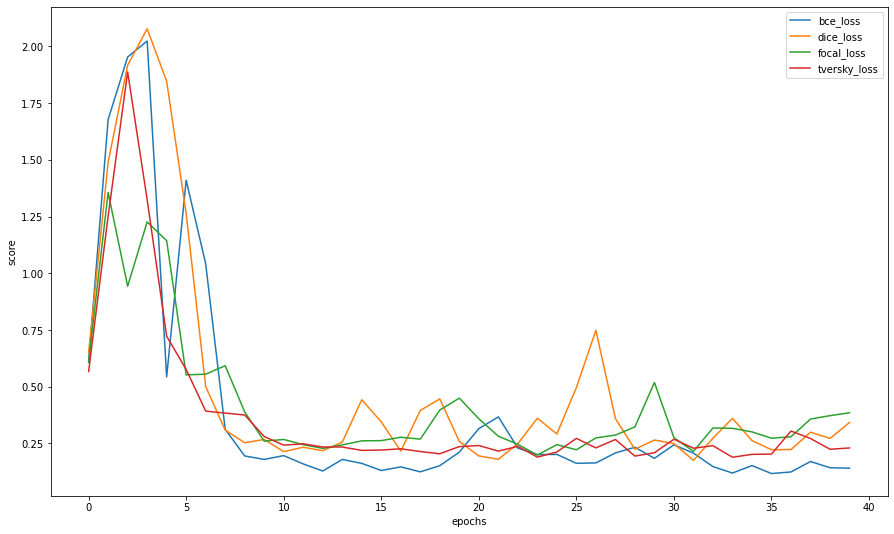

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_unet_bce, label="bce_loss")
plt.plot(val_loss_unet_dice, label="dice_loss")
plt.plot(val_loss_unet_focal, label="focal_loss")
plt.plot(val_loss_unet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Val score

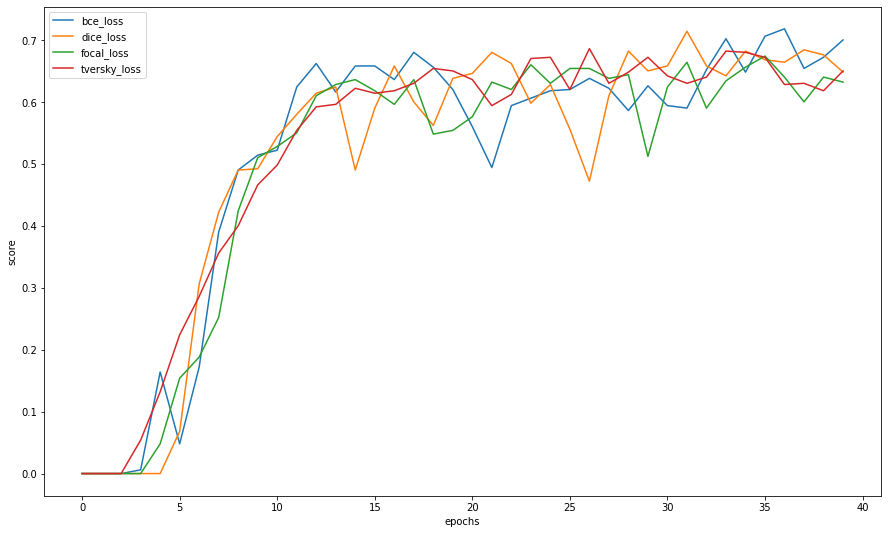

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_unet_bce, label="bce_loss")
plt.plot(score_val_unet_dice, label="dice_loss")
plt.plot(score_val_unet_focal, label="focal_loss")
plt.plot(score_val_unet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Test loss

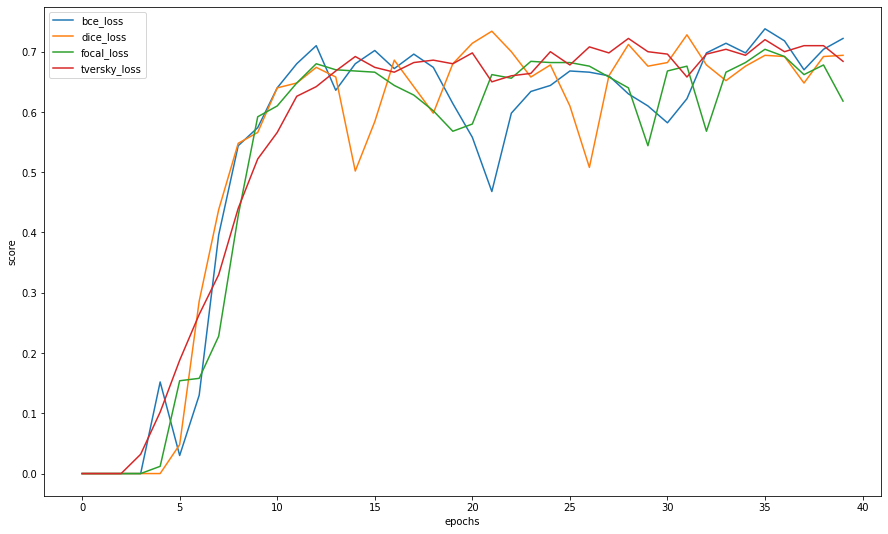

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_unet_bce, label="bce_loss")
plt.plot(score_test_unet_dice, label="dice_loss")
plt.plot(score_test_unet_focal, label="focal_loss")
plt.plot(score_test_unet_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

### UNet2

Train loss

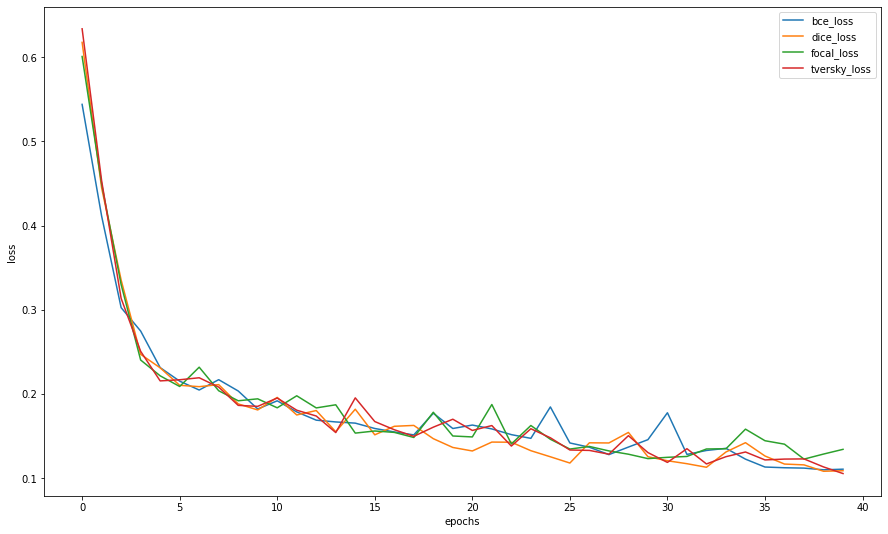

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_unet2_bce, label="bce_loss")
plt.plot(train_loss_unet2_dice, label="dice_loss")
plt.plot(train_loss_unet2_focal, label="focal_loss")
plt.plot(train_loss_unet2_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

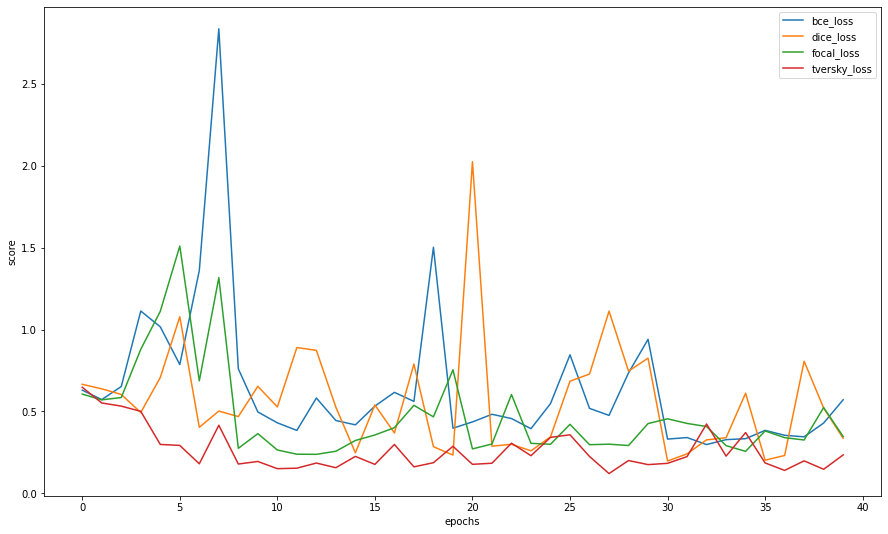

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_unet2_bce, label="bce_loss")
plt.plot(val_loss_unet2_dice, label="dice_loss")
plt.plot(val_loss_unet2_focal, label="focal_loss")
plt.plot(val_loss_unet2_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Val score

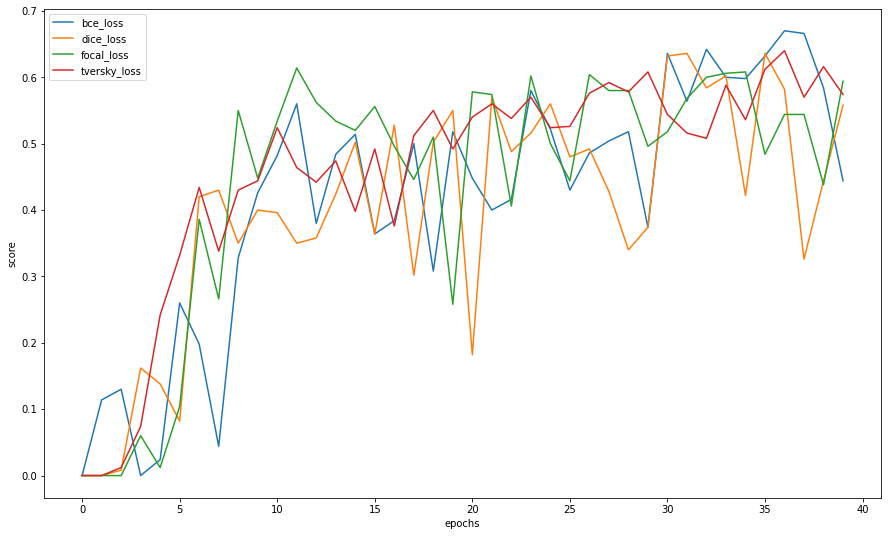

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_unet2_bce, label="bce_loss")
plt.plot(score_val_unet2_dice, label="dice_loss")
plt.plot(score_val_unet2_focal, label="focal_loss")
plt.plot(score_val_unet2_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Test score

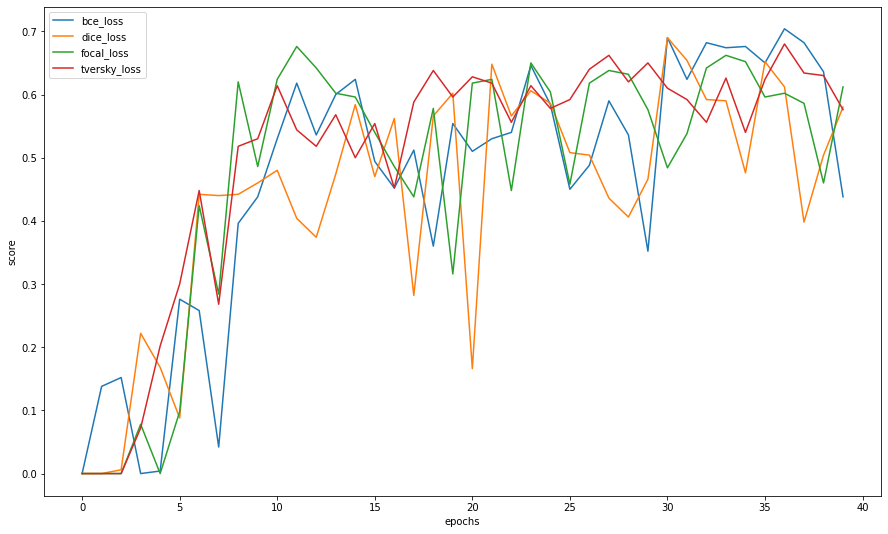

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_unet2_bce, label="bce_loss")
plt.plot(score_test_unet2_dice, label="dice_loss")
plt.plot(score_test_unet2_focal, label="focal_loss")
plt.plot(score_test_unet2_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

### DilatedUNet

Train loss

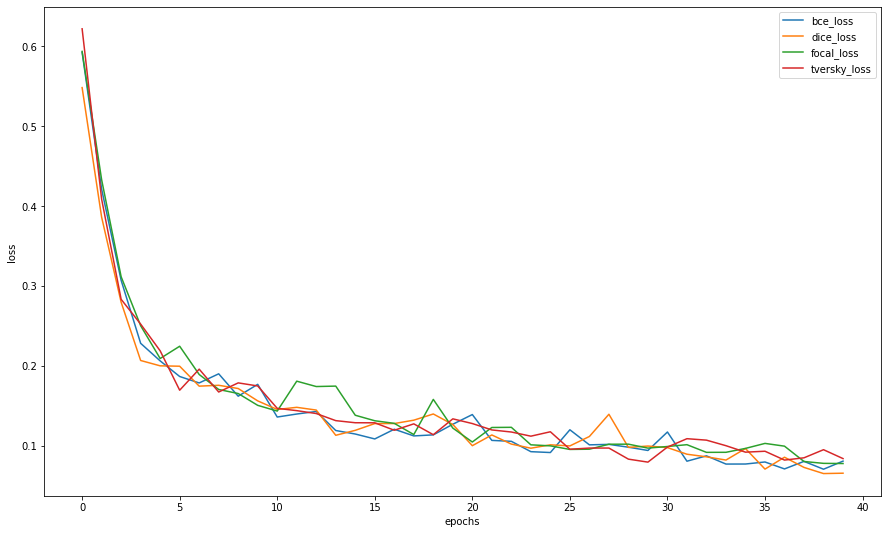

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_dilated_bce, label="bce_loss")
plt.plot(train_loss_dilated_dice, label="dice_loss")
plt.plot(train_loss_dilated_focal, label="focal_loss")
plt.plot(train_loss_dilated_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

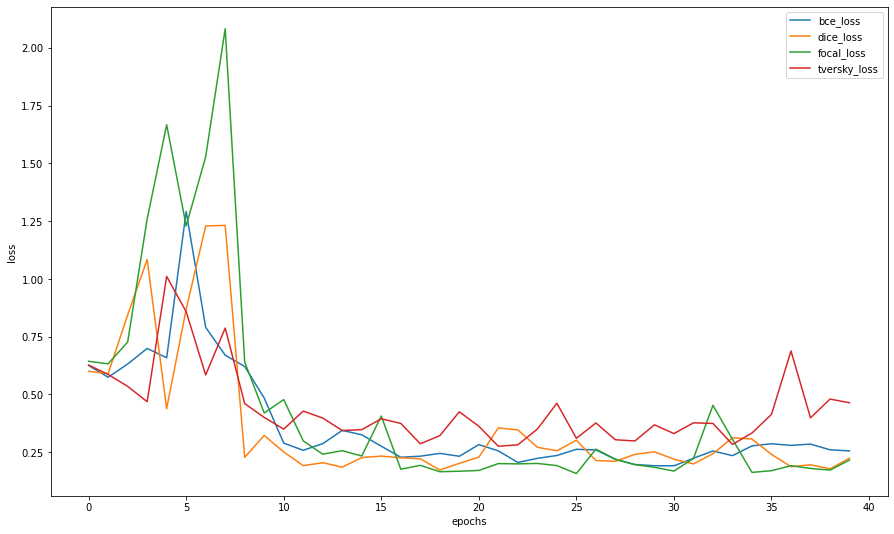

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_dilated_bce, label="bce_loss")
plt.plot(val_loss_dilated_dice, label="dice_loss")
plt.plot(val_loss_dilated_focal, label="focal_loss")
plt.plot(val_loss_dilated_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val score

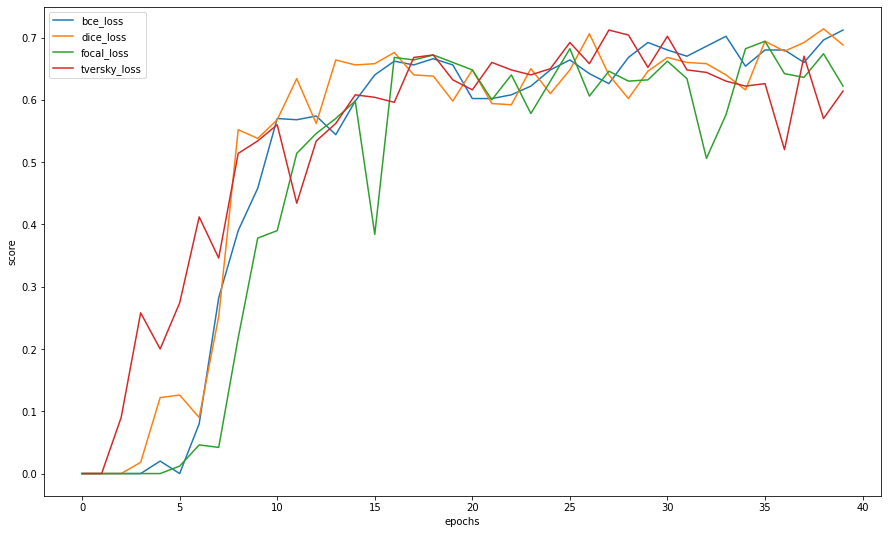

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_dilated_bce, label="bce_loss")
plt.plot(score_val_dilated_dice, label="dice_loss")
plt.plot(score_val_dilated_focal, label="focal_loss")
plt.plot(score_val_dilated_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Test score

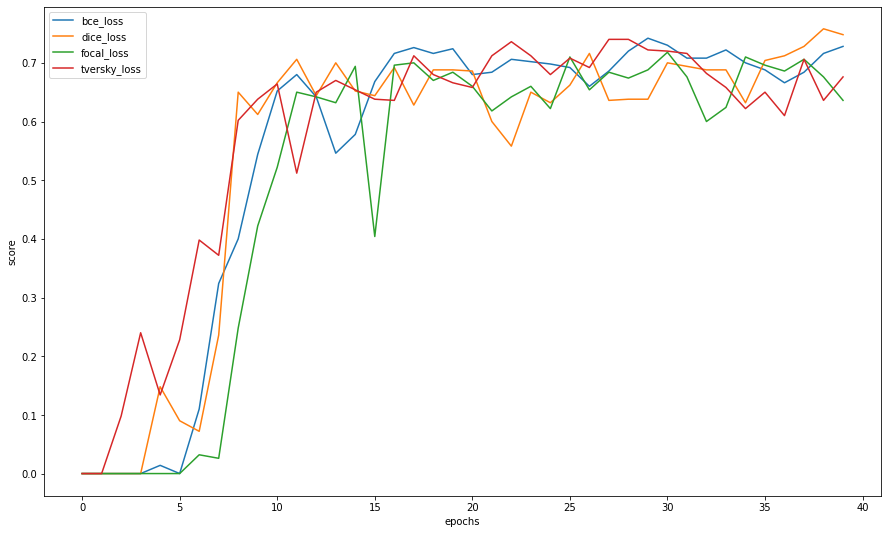

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_dilated_bce, label="bce_loss")
plt.plot(score_test_dilated_dice, label="dice_loss")
plt.plot(score_test_dilated_focal, label="focal_loss")
plt.plot(score_test_dilated_tversky, label="tversky_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

По графикам видно, что лучшей моделью на всех лоссах является DilatedUNet.

## По лоссам

### BCE loss

Train loss

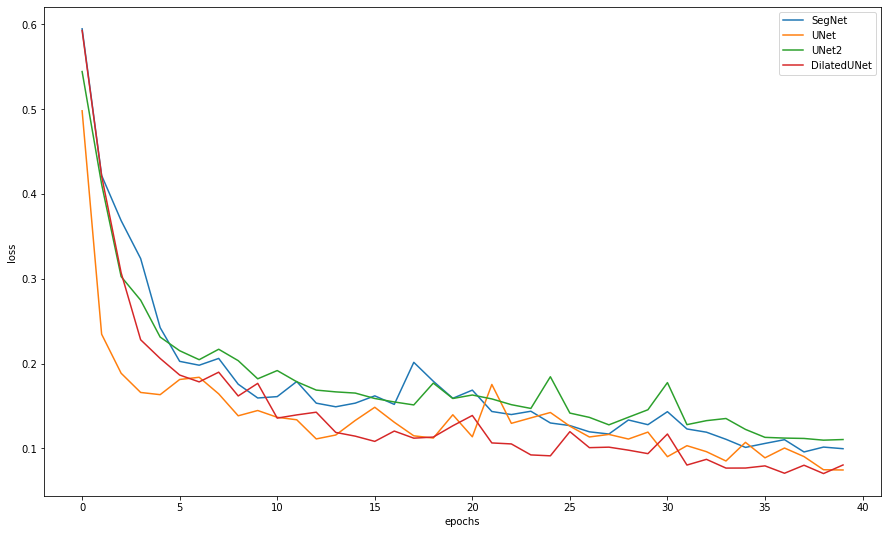

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_segnet_bce, label="SegNet")
plt.plot(train_loss_unet_bce, label="UNet")
plt.plot(train_loss_unet2_bce, label="UNet2")
plt.plot(train_loss_dilated_bce, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

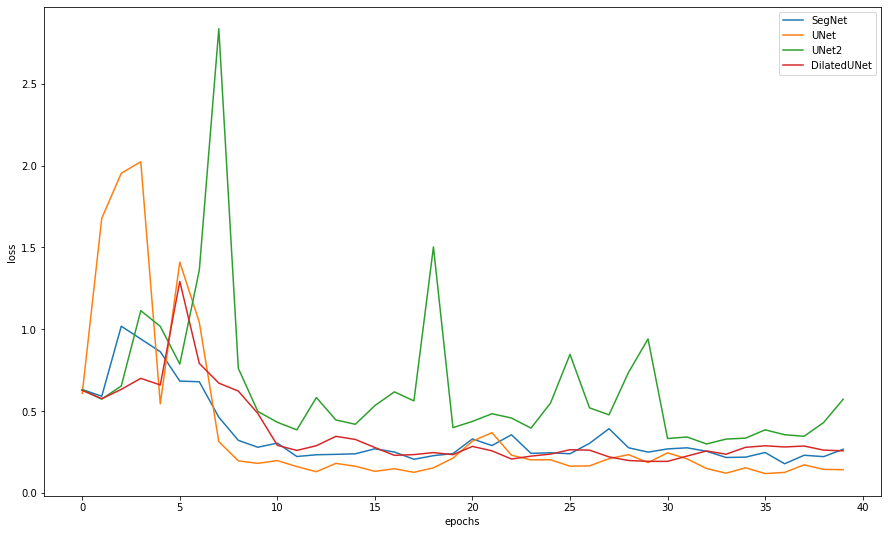

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_segnet_bce, label="SegNet")
plt.plot(val_loss_unet_bce, label="UNet")
plt.plot(val_loss_unet2_bce, label="UNet2")
plt.plot(val_loss_dilated_bce, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val score

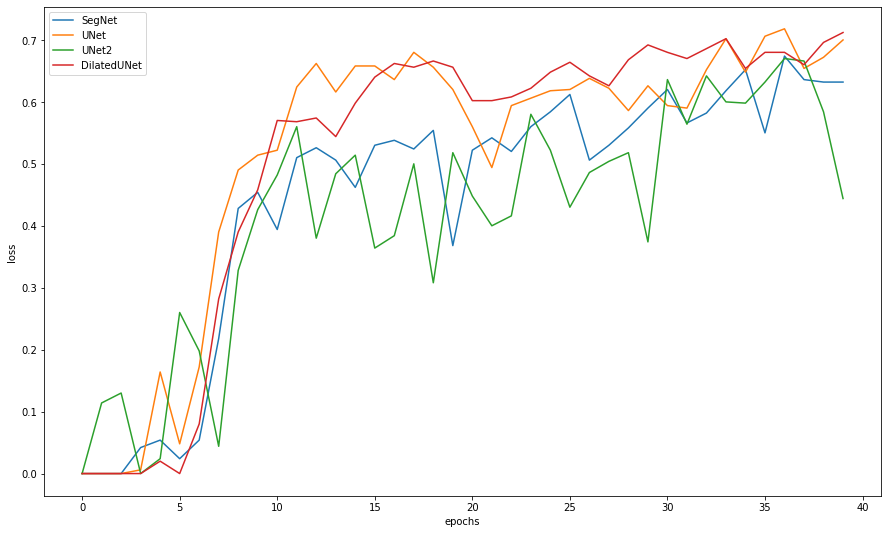

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_segnet_bce, label="SegNet")
plt.plot(score_val_unet_bce, label="UNet")
plt.plot(score_val_unet2_bce, label="UNet2")
plt.plot(score_val_dilated_bce, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Test score

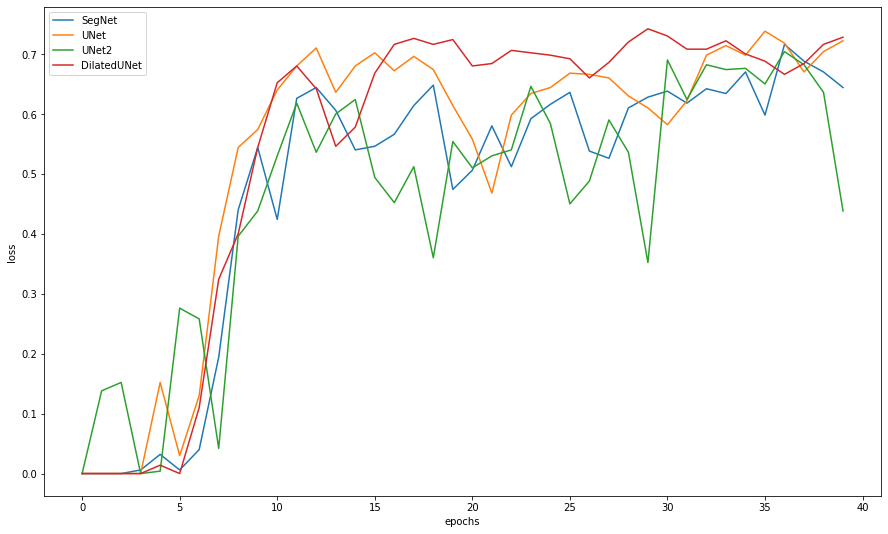

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_segnet_bce, label="SegNet")
plt.plot(score_test_unet_bce, label="UNet")
plt.plot(score_test_unet2_bce, label="UNet2")
plt.plot(score_test_dilated_bce, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### DICE loss

Train loss

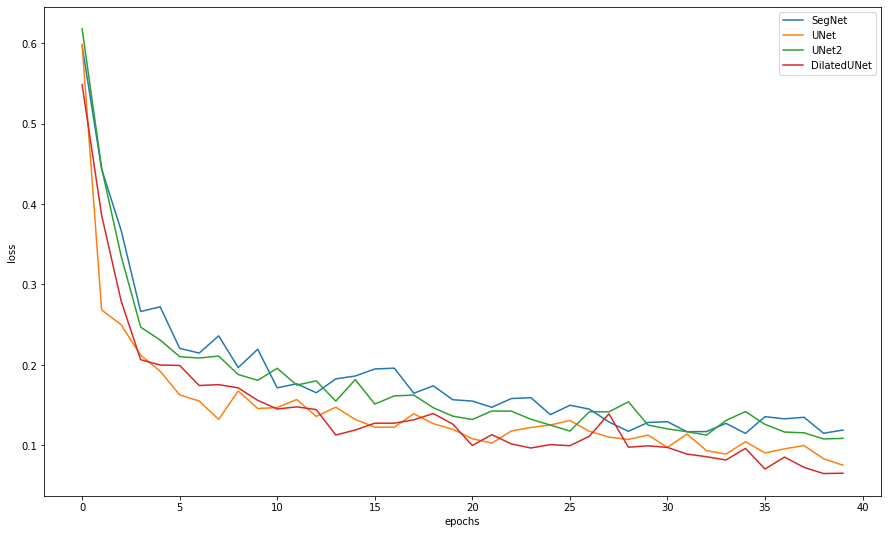

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_segnet_dice, label="SegNet")
plt.plot(train_loss_unet_dice, label="UNet")
plt.plot(train_loss_unet2_dice, label="UNet2")
plt.plot(train_loss_dilated_dice, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

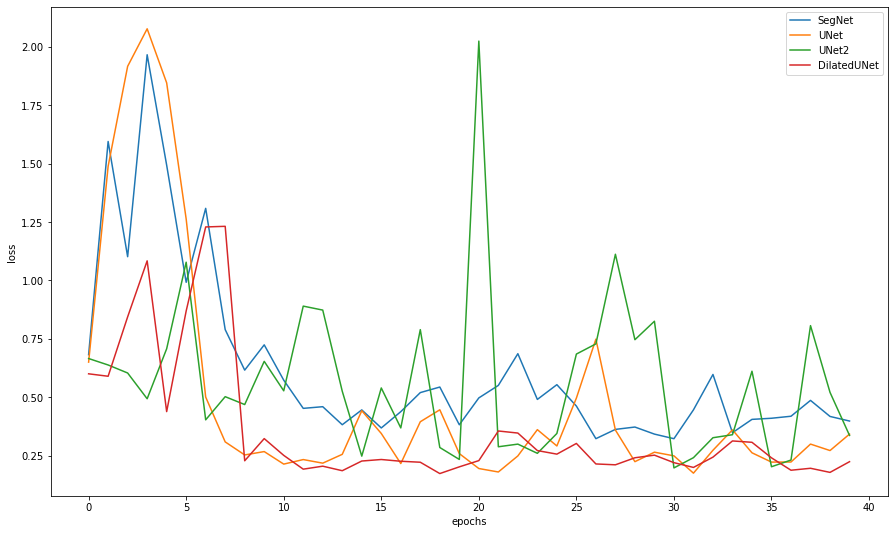

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_segnet_dice, label="SegNet")
plt.plot(val_loss_unet_dice, label="UNet")
plt.plot(val_loss_unet2_dice, label="UNet2")
plt.plot(val_loss_dilated_dice, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val score

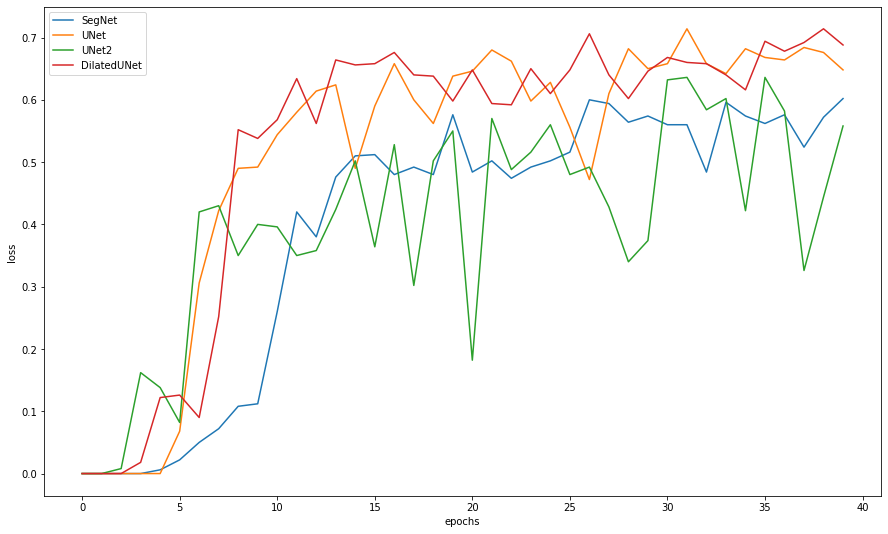

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_segnet_dice, label="SegNet")
plt.plot(score_val_unet_dice, label="UNet")
plt.plot(score_val_unet2_dice, label="UNet2")
plt.plot(score_val_dilated_dice, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Test score

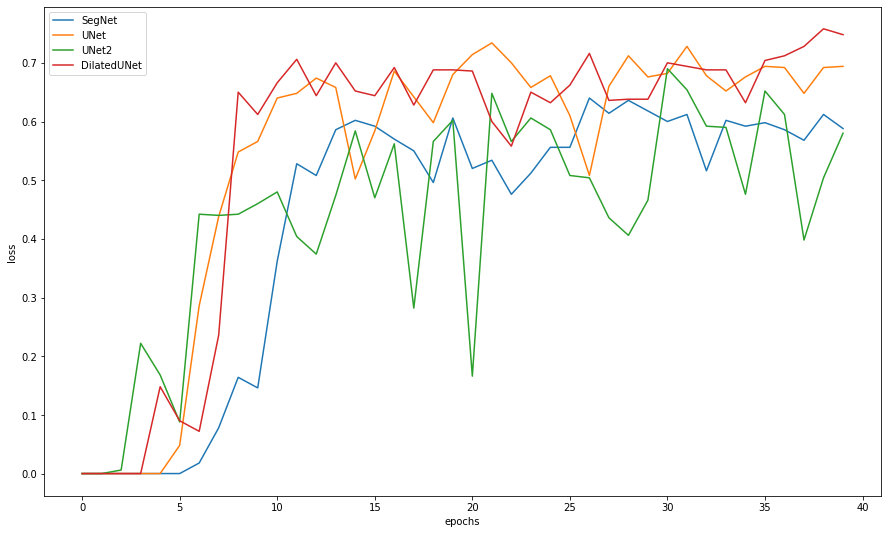

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_segnet_dice, label="SegNet")
plt.plot(score_test_unet_dice, label="UNet")
plt.plot(score_test_unet2_dice, label="UNet2")
plt.plot(score_test_dilated_dice, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### FOCAL loss

Train loss

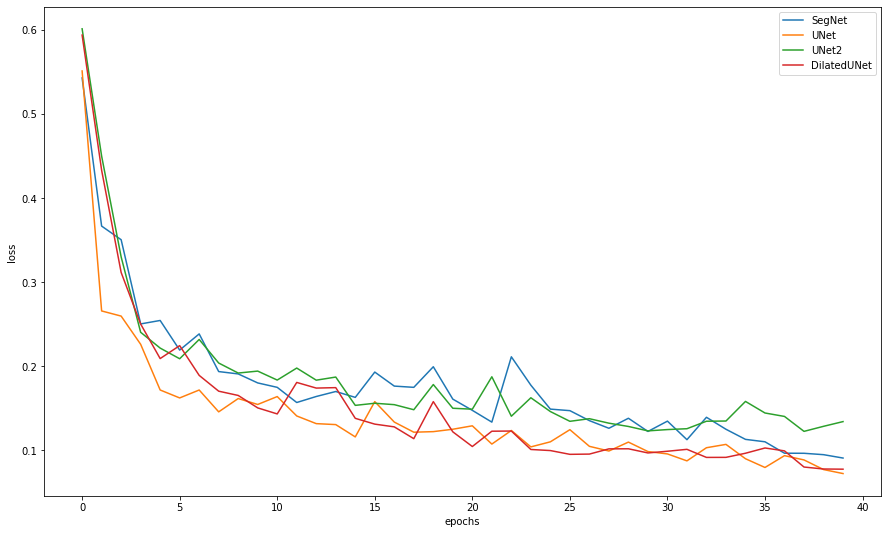

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_segnet_focal, label="SegNet")
plt.plot(train_loss_unet_focal, label="UNet")
plt.plot(train_loss_unet2_focal, label="UNet2")
plt.plot(train_loss_dilated_focal, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

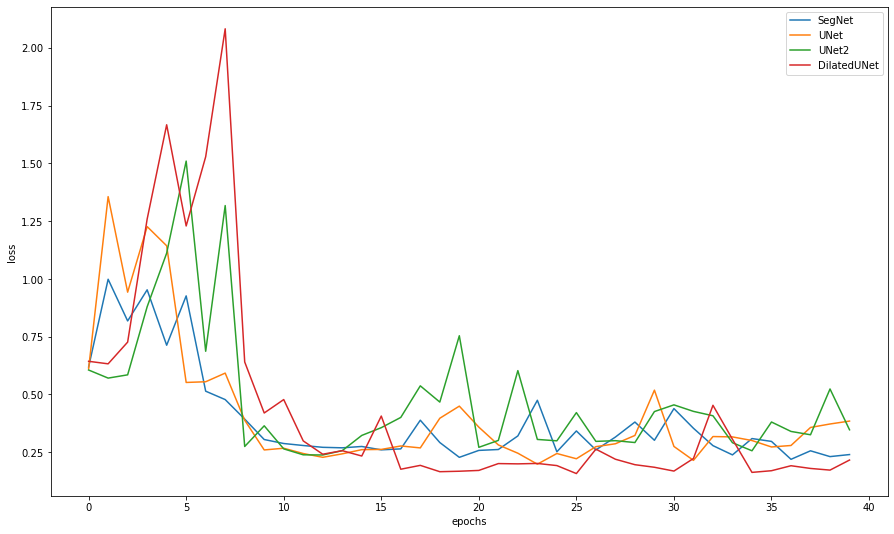

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_segnet_focal, label="SegNet")
plt.plot(val_loss_unet_focal, label="UNet")
plt.plot(val_loss_unet2_focal, label="UNet2")
plt.plot(val_loss_dilated_focal, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val score

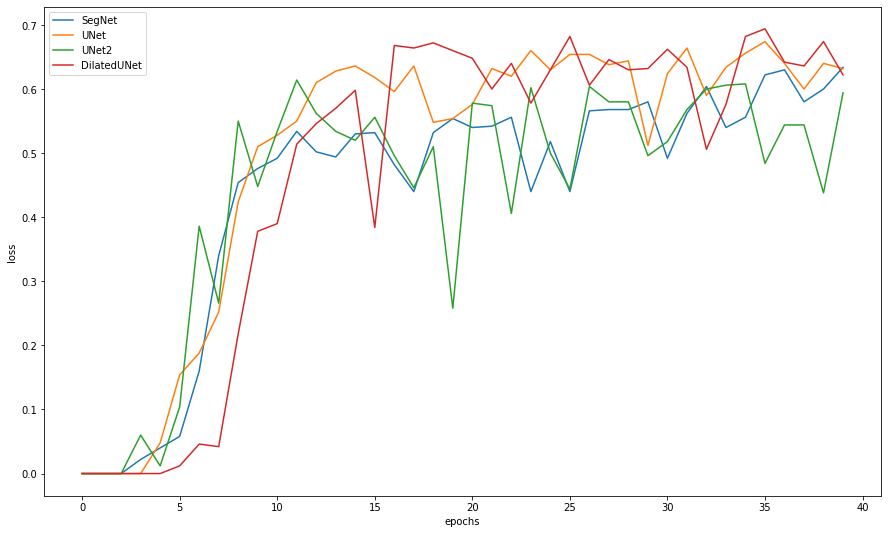

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_segnet_focal, label="SegNet")
plt.plot(score_val_unet_focal, label="UNet")
plt.plot(score_val_unet2_focal, label="UNet2")
plt.plot(score_val_dilated_focal, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Test score

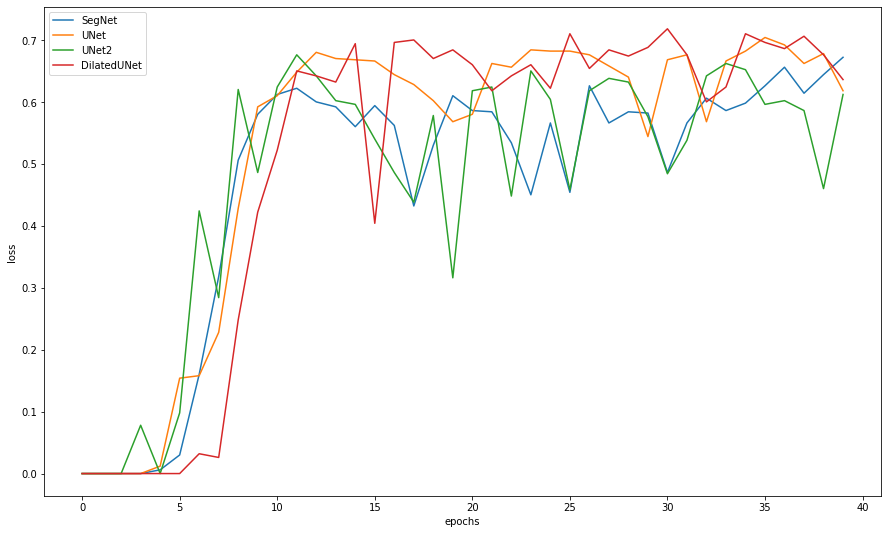

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_segnet_focal, label="SegNet")
plt.plot(score_test_unet_focal, label="UNet")
plt.plot(score_test_unet2_focal, label="UNet2")
plt.plot(score_test_dilated_focal, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### TVERSKY loss

Train loss

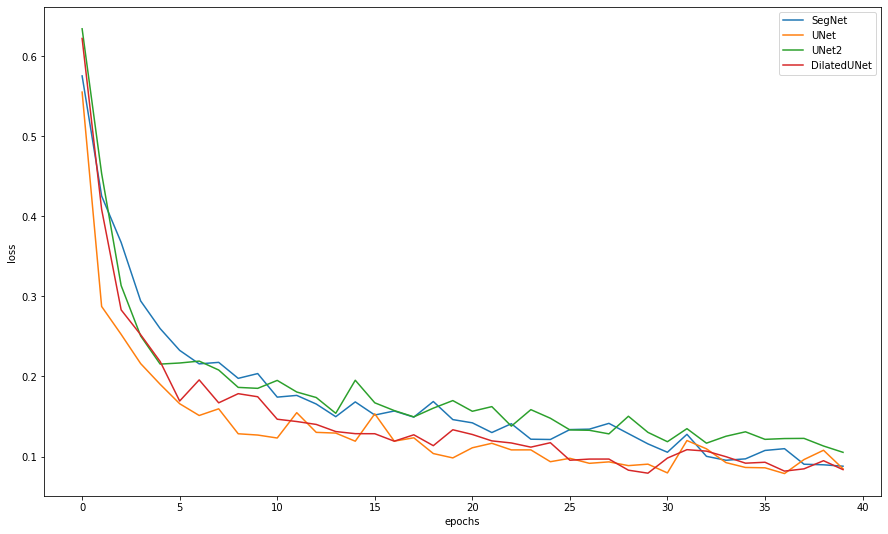

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_segnet_tversky, label="SegNet")
plt.plot(train_loss_unet_tversky, label="UNet")
plt.plot(train_loss_unet2_tversky, label="UNet2")
plt.plot(train_loss_dilated_tversky, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val loss

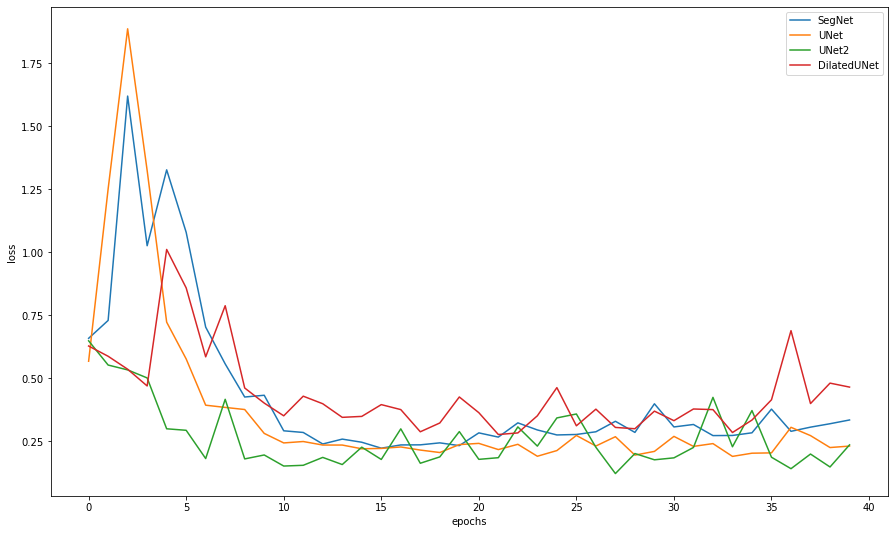

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(val_loss_segnet_tversky, label="SegNet")
plt.plot(val_loss_unet_tversky, label="UNet")
plt.plot(val_loss_unet2_tversky, label="UNet2")
plt.plot(val_loss_dilated_tversky, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Val score

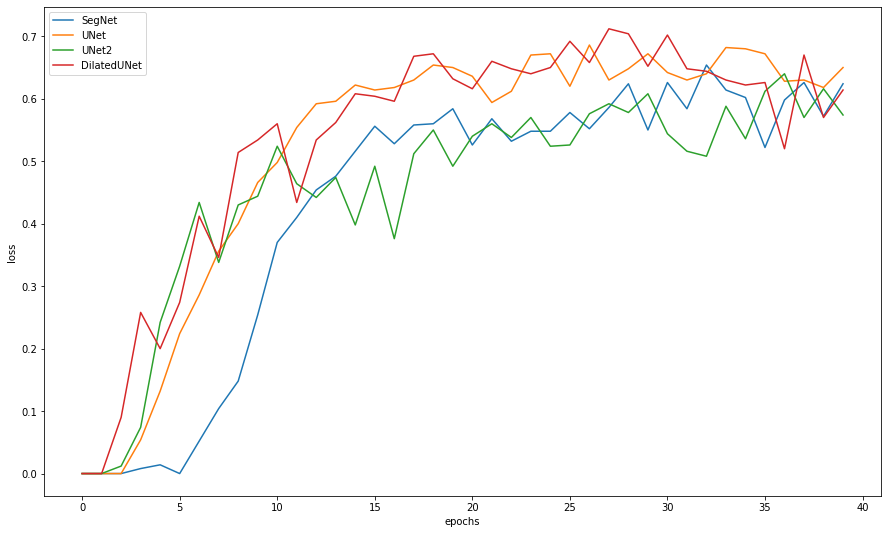

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_val_segnet_tversky, label="SegNet")
plt.plot(score_val_unet_tversky, label="UNet")
plt.plot(score_val_unet2_tversky, label="UNet2")
plt.plot(score_val_dilated_tversky, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Test score

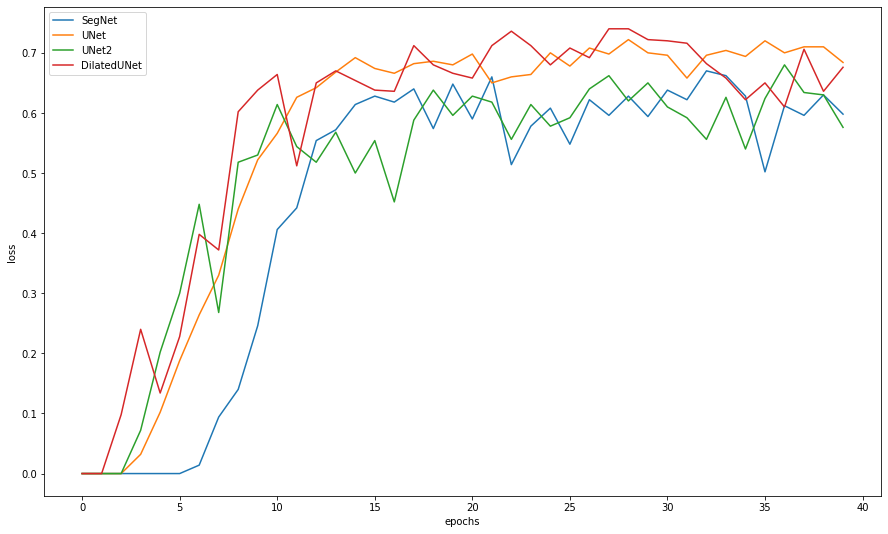

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(score_test_segnet_tversky, label="SegNet")
plt.plot(score_test_unet_tversky, label="UNet")
plt.plot(score_test_unet2_tversky, label="UNet2")
plt.plot(score_test_dilated_tversky, label="DilatedUNet")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

 По график видно, что наиболее стабильной на (относительно) всех моделях стал tversky loss. Это можно объяснить тем, что tversky наиболее адаптирован для сегментации.

### Вывод:

Лучшее сочитание модели и функции loss, я считаю, является DilatedUNet with Tversky loss, либо DilatedUNet with Dice loss. Для более точного сравнения необходимы последущие измерения и больше обучения с различными lerning rate.